## Assignemnt : Deep Learning with CNNs

### Prasanth Dwadasi

### Abstract:
This notebook compares various hyperparameters and thier effects on the accuracy of model we implement
The Model is a CNN with 3 hidden layers which classifies TMNIST characters

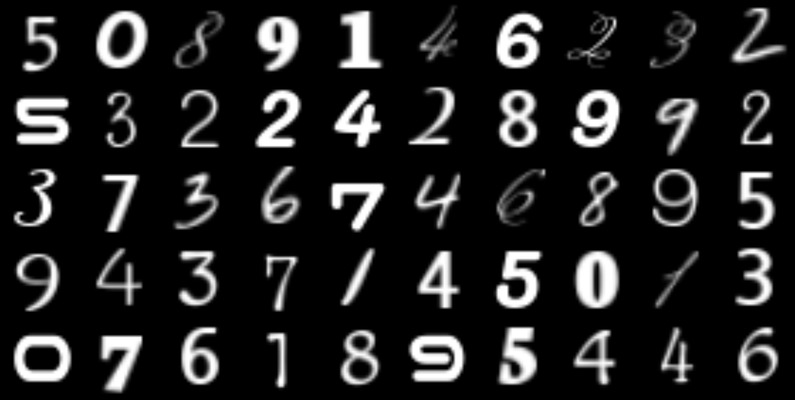

In [71]:
#importing the libraries
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import warnings
import time
warnings.filterwarnings("ignore")

**Importing the Dataset**

In [3]:
#Importing Dataset
data = pd.read_csv("./94_character_TMNIST.csv")

The TMNIST database, which contains a sizable collection of handwritten alphabets, numbers, and special characters, is frequently used to train different image processing algorithms. In the field of machine learning, this database is frequently used for testing and training purposes.
I'll be utilizing CNN (Convolutional Neural Network), a deep learning method with a functional model. The use of a functional model is necessary to keep things simple while linking the layers.

In [4]:
data.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Dataset Characteristics
print(f"The Shape of the Dataset is: {data.shape}")
print(f"Number of Samples: {data.shape[0]}")
print(f"Number of Features: {data.shape[1]}")

The Shape of the Dataset is: (274093, 786)
Number of Samples: 274093
Number of Features: 786


In [6]:
# Number of unique character in the Dataframe
num_unique_chars = len(data.labels.unique())
print(f"Number of unique character present in the Dataset: {num_unique_chars}")

Number of unique character present in the Dataset: 94


In [7]:
#All Unique Chars
all_unique_chars = list(data.labels.unique())
print(all_unique_chars)

['6', 'D', 'f', '/', 'F', 'x', 'J', '8', 'H', 'k', '@', '1', '=', 'g', ')', '2', 'd', '^', '3', 't', '#', '.', '4', 'o', '"', 'y', 'A', 'u', 'G', '-', 'm', 'W', '&', 'c', '9', 'N', ']', 'P', 'X', '|', '}', 'h', '7', 'j', '5', '>', '?', 'b', '*', 'w', 'l', '0', '$', 'I', 'Y', '%', ':', 'T', 'K', 'E', '<', 'V', '{', 'M', 'S', 'a', 'i', 'r', "'", 'p', ';', '[', '+', 'e', 'U', '(', 's', '~', ',', 'C', 'q', '_', 'n', 'B', 'z', 'v', 'O', 'R', '`', 'Z', 'Q', 'L', '!', '\\']


In [8]:
#Drop redundant coloums (names and labels), retain only pixel values
x = data.drop(columns=['names','labels']).values
y = data[['labels']].values #Assigning Classes

In [33]:
#Convert NumPy array to Pandas Dataframe for ease of processing downstream and triaging
df_x = pd.DataFrame(x)
df_y = pd.DataFrame(y)

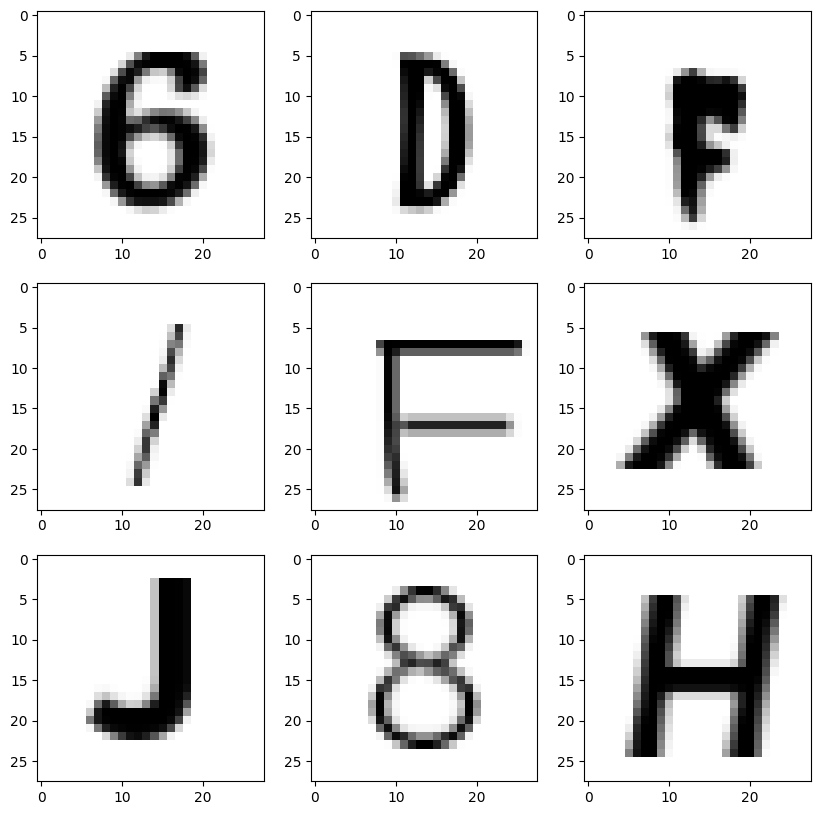

In [36]:
# sample reshaped characters of the dataset
x_images = x.reshape(-1,28,28)
fig,axs = plt.subplots(3,3,figsize=(10,10))
for i in range(9):
    r=i//3
    c=i%3
    axs[r][c].imshow(x_images[i], cmap="Greys")
plt.show()

Here, we can see that the dataset consists various uppercase and lowercase characters along with numbers/ digits both in english. It also contains various special characters eg. @ and = .

Splitting Dataset into Testing and Training Sets

In [11]:
#Split dataset into Train & Test @ 80% and 20% spread respectively
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

In [12]:
#Shape of training Data
print(f'X:Train, Test data shape:{X_train.shape},{X_test.shape}')
print(f'Y:Train, Test data shape:{y_train.shape},{y_test.shape}')

X:Train, Test data shape:(219274, 784),(54819, 784)
Y:Train, Test data shape:(219274, 1),(54819, 1)


Preparing the Training and Testing Dataset - Data Preprocessing

In [13]:
#the pixel values are from 0-255, normalizing the dataset for neural network models, converting them to values between 0-1 
X_train= (X_train.astype('float32'))/255.0
X_test = (X_test.astype('float32'))/255.0

In [14]:
#encoding the y values
char_enc = OneHotEncoder(sparse=False,handle_unknown='ignore')
y_train_encoded= char_enc.fit_transform(y_train.values.reshape(-1,1))
y_test_encoded=  char_enc.transform(y_test.values.reshape(-1,1))

In [15]:
X_train_norm=X_train.values.reshape(X_train.shape[0],28,28)
X_test_norm=X_test.values.reshape(X_test.shape[0],28,28)

# **Neural Network CNN Model Definition**

Basic Neural Network Model with 3 hidden layers

In [16]:
#ModelDefinition
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_unique_chars, activation='softmax'))
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1


2022-11-19 12:26:49.136664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-19 12:26:49.138973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 94)                3102      
                                                                 
Total params: 474,814
Trainable params: 474,814
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Fitting the basic model
model_history=model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=2,batch_size=128)



Epoch 1/20


2022-11-19 12:32:26.517552: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-19 12:32:26.875929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 12:32:43.821679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1714/1714 - 20s - loss: 0.8269 - accuracy: 0.7828 - val_loss: 0.5059 - val_accuracy: 0.8482 - 20s/epoch - 12ms/step
Epoch 2/20
1714/1714 - 16s - loss: 0.4485 - accuracy: 0.8639 - val_loss: 0.4206 - val_accuracy: 0.8730 - 16s/epoch - 9ms/step
Epoch 3/20
1714/1714 - 16s - loss: 0.3769 - accuracy: 0.8800 - val_loss: 0.3841 - val_accuracy: 0.8763 - 16s/epoch - 10ms/step
Epoch 4/20
1714/1714 - 16s - loss: 0.3311 - accuracy: 0.8918 - val_loss: 0.3549 - val_accuracy: 0.8903 - 16s/epoch - 10ms/step
Epoch 5/20
1714/1714 - 16s - loss: 0.2961 - accuracy: 0.9014 - val_loss: 0.3394 - val_accuracy: 0.8909 - 16s/epoch - 9ms/step
Epoch 6/20
1714/1714 - 560s - loss: 0.2707 - accuracy: 0.9095 - val_loss: 0.3384 - val_accuracy: 0.8923 - 560s/epoch - 327ms/step
Epoch 7/20
1714/1714 - 17s - loss: 0.2490 - accuracy: 0.9151 - val_loss: 0.3375 - val_accuracy: 0.8929 - 17s/epoch - 10ms/step
Epoch 8/20
1714/1714 - 16s - loss: 0.2307 - accuracy: 0.9203 - val_loss: 0.3246 - val_accuracy: 0.9032 - 16s/epoch - 10ms

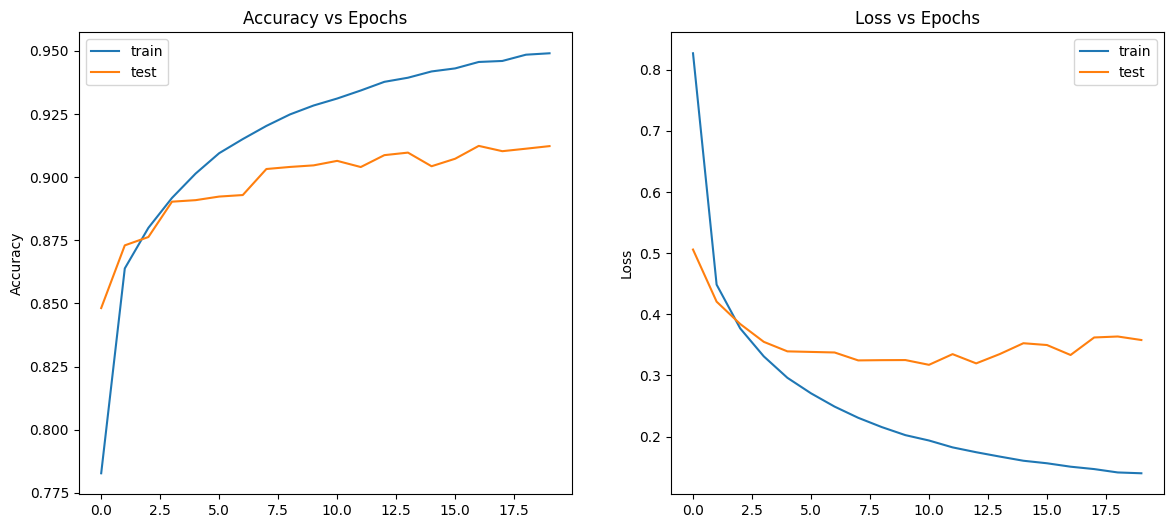

In [18]:
#Plotting Results
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
epochs=np.arange(20)
plt.title('Accuracy vs Epochs')
plt.plot(epochs,model_history.history['accuracy'],label='train_accuracy')
plt.ylabel('Accuracy')
plt.plot(epochs,model_history.history['val_accuracy'],label='test_accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss vs Epochs')
plt.plot(epochs,model_history.history['loss'],label='train_loss')
plt.ylabel('Loss')
plt.plot(epochs,model_history.history['val_loss'],label='test_loss')
plt.legend()
plt.show()

## **Conclusions**

- The final testing accuracy after 20n epochs of training is 91.23 
- We can observe from the graph that the training accuracy continues to increase while the validation loss
  plateaus after 15 epochs. Similar behaviou is observed for loss

## PART B - ACTIVATION FUNCTION (10 POINTS)

On your Deep Learning model data
Change the activation function. How does it affect accuracy? How does it affect how quickly the network plateaus?

Various activation functions:  

- Rectified linear unit (ReLU)
- TanH
- Leaky rectified linear unit (Leaky ReLU)
- Parameteric rectified linear unit (PReLU) Randomized leaky rectified linear unit (RReLU)
- Exponential linear unit (ELU)
- Scaled exponential linear unit (SELU)
- S-shaped rectified linear activation unit (SReLU)
- Adaptive piecewise linear (APL)


In [84]:
#ModelDefinition
activations= ['relu','tanh','leaky_relu','elu','selu']
accuracies_activation = []
models_activation = []
time_taken_activation = []

for i,act in enumerate(activations):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(512,activation=act))
    model.add(Dense(128,activation=act))
    model.add(Dense(32, activation=act))
    model.add(Dense(num_unique_chars, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    models_activation.append(model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=0,batch_size=128))
    time_taken_activation.append(time.time() - start)
    accuracies_activation.append(models_losses[i].history['accuracy'][-1])
    

2022-11-19 21:42:55.640842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 21:43:16.713931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 21:51:27.982665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 21:51:50.607584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 22:01:33.368611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 22:01:54.914835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 22:10:07.253715: I tensorflow/core/grappler/optimizers/cust

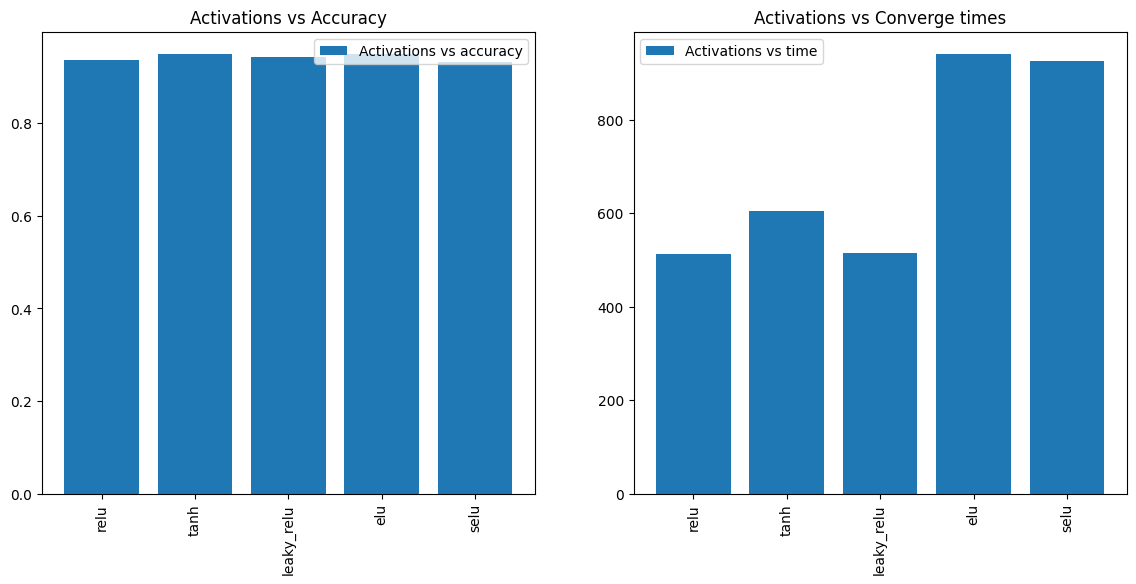

In [88]:
#Plotting Results
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title('Activations vs Accuracy')
plt.xticks(rotation='vertical')
plt.bar(activations,accuracies_activation,label='Activations vs accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.title('Activations vs Converge times')
plt.xticks(rotation='vertical')
plt.bar(activations,time_taken_activation,label='Activations vs time')
plt.legend()
plt.show()

## **Conclusions**

- The accuracies are mostly similar for all activations
- The time taken for relu and leaky_relu were the lowest as they are linear(mostly)

## PART C - COST FUNCTION (10 POINTS)  On your Deep Learning model.  

Change the cost function. How does it affect accuracy? How does it affect how quickly the network plateaus?
Various forms of cost: 
- Quadratic cost (mean-square error)
- Cross-Entropy
- Hinge
- Kullback–Leibler divergence
- Cosine Proximity

In [55]:
#ModelDefinition
losses= ['mean_squared_error','categorical_crossentropy','categorical_hinge','kullback_leibler_divergence','cosine_similarity']
accuracies_losses = []
models_losses = []
time_taken_losses = []

for i,loss in enumerate(losses):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_unique_chars, activation='softmax'))
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
    start = time.time()
    models_losses.append(model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=0,batch_size=128))
    time_taken_losses.append(time.time() - start)
    accuracies_losses.append(models_losses[i].history['accuracy'][-1])
    

2022-11-19 17:57:28.080602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 17:57:38.622829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:01:02.475851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:01:17.743717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:07:10.160003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:07:21.078370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:10:57.681674: I tensorflow/core/grappler/optimizers/cust

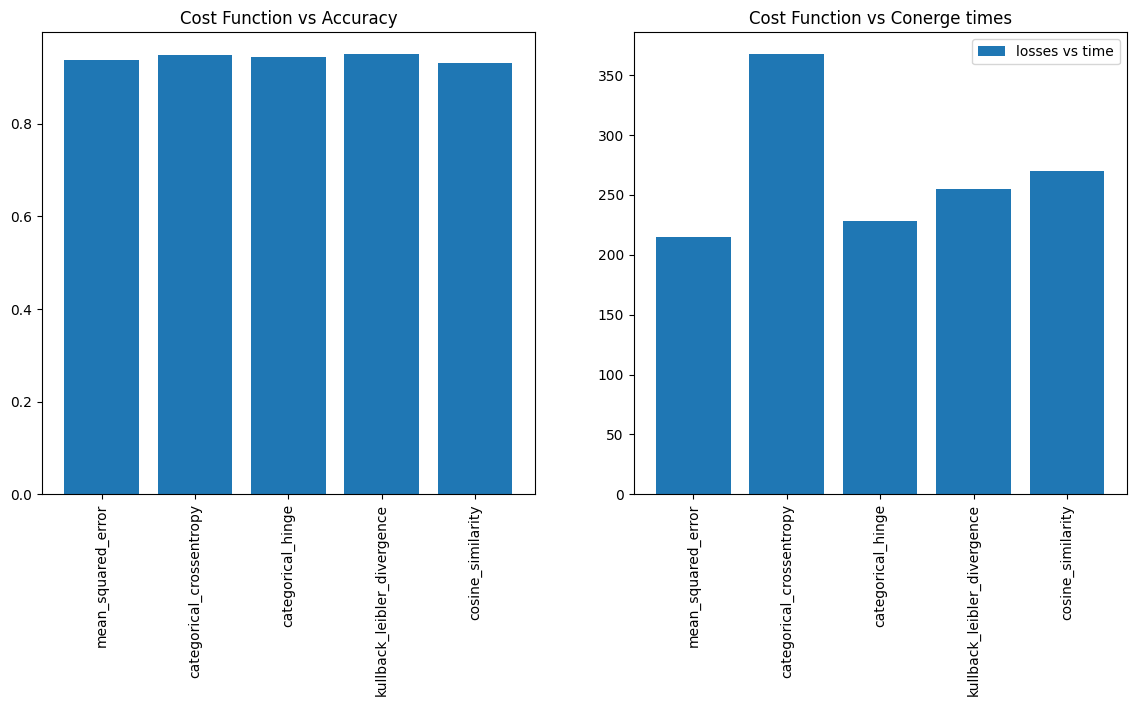

In [90]:
#Plotting Results
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title('Cost Function vs Accuracy')
plt.xticks(rotation='vertical')
plt.bar(losses,accuracies_losses,label='losses vs accuracy')


plt.subplot(1,2,2)
plt.title('Cost Function vs Conerge times')
plt.xticks(rotation='vertical')
plt.bar(losses,time_taken_losses,label='losses vs time')
plt.legend()
plt.show()

## **Conclusions**
- We can observe that categotrical cross entropy is the fastest among other losses
- The accuracy is similar among all losses with KL and cosine being slighly higher

## PART D - EPOCHS (10 POINTS)

On your Deep Learning model data
Change the number of epochs initialization. How does it affect accuracy?
How quickly does the network plateau?

In [61]:
#ModelDefinition
epochs= [10,20,40,80]
accuracies_epochs = []
models_epochs = []
time_taken_epochs = []

for i,epoch in enumerate(epochs):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_unique_chars, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    models_epochs.append(model.fit(X_train_norm, y_train_encoded, epochs=epoch, validation_data=(X_test_norm, y_test_encoded), verbose=0,batch_size=128))
    time_taken_epochs.append(time.time() - start)
    accuracies_epochs.append(models_losses[i].history['accuracy'][-1])  
    

2022-11-19 18:28:37.386118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:28:54.653536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:31:56.780158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:32:13.139919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:38:25.579804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:38:42.045171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:51:21.311784: I tensorflow/core/grappler/optimizers/cust

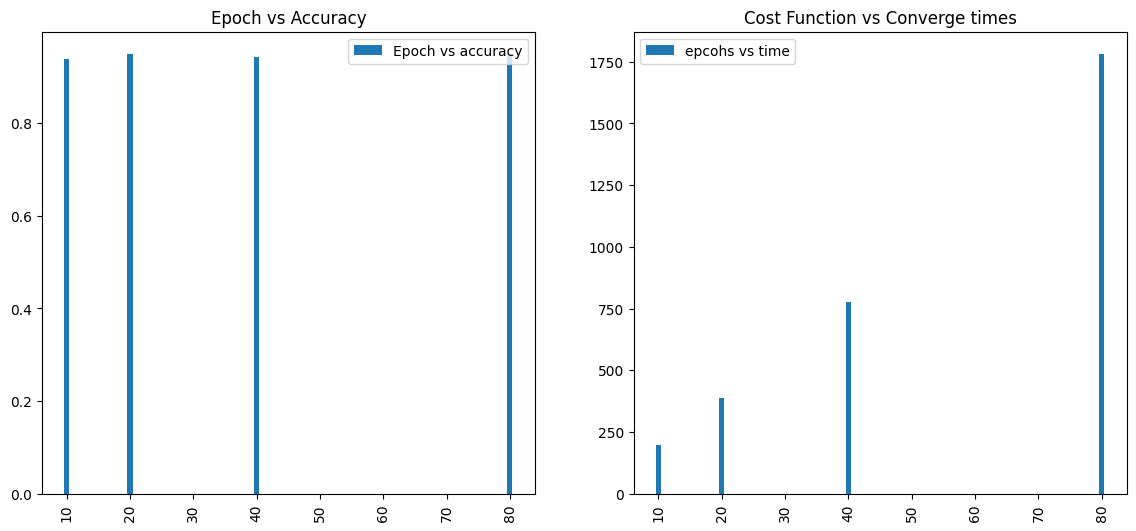

In [101]:
#Plotting Results
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title('Epoch vs Accuracy')
plt.xticks(rotation='vertical')
plt.bar(epochs,accuracies_epochs,label='Epoch vs accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.title('Cost Function vs Converge times')
plt.xticks(rotation='vertical')
plt.bar(epochs,time_taken_epochs,label='epcohs vs time')
plt.legend()
plt.show()

## **Conclusions**
- The accuracy stabilises after 20 epochs as we seen in partA and this graph proves that
- The time it runs increases as the epochs increases as it should be

## PART E - GRADIENT ESTIMATION (10 POINTS)
On your Deep Learning model

Change the gradient estimation. How does it affect accuracy? How does it affect how quickly the network plateaus?
Various forms of gradient estimation:
- Stochastic Gradient Descent
- Adagrad
- RMSProp
- ADAM
- Adadelta


In [64]:
#ModelDefinition
optimizers= ['SGD','Adagrad','RMSprop','Adam','Adadelta']
accuracies_optimizers = []
models_optimizers = []
time_taken_optimizers = []

for i,opt in enumerate(optimizers):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_unique_chars, activation='softmax'))
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    start = time.time()
    models_optimizers.append(model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=0,batch_size=128))
    time_taken_optimizers.append(time.time() - start)
    accuracies_optimizers.append(models_losses[i].history['accuracy'][-1])  
    

2022-11-19 19:21:05.450129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:21:16.729778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:25:48.952809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:26:01.175319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:30:20.640212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:30:39.736697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:37:23.578047: I tensorflow/core/grappler/optimizers/cust

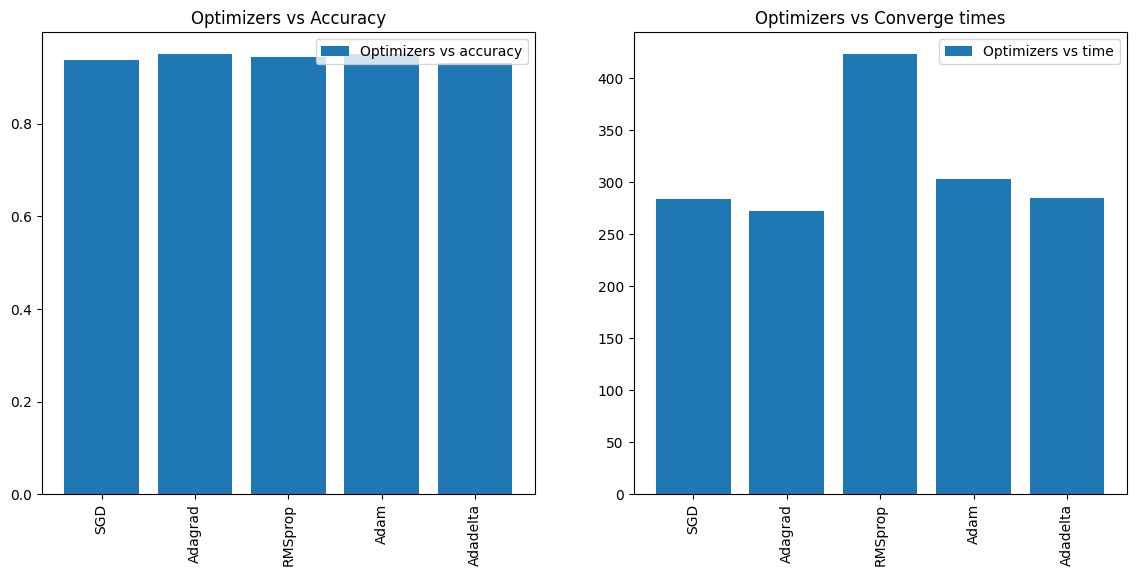

In [103]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title('Optimizers vs Accuracy')
plt.xticks(rotation='vertical')
plt.bar(optimizers,accuracies_optimizers,label='Optimizers vs accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.title('Optimizers vs Converge times')
plt.xticks(rotation='vertical')
plt.bar(optimizers,time_taken_optimizers,label='Optimizers vs time')
plt.legend()
plt.show()

## **Conclusions**

- The accuracy is almost similar for all optimizers which shows the local minima is attained
- The RMSProp took more time to reach mininma and Adagrad seems the fastsest for this model

## PART F - NETWORK ARCHITECTURE (10 POINTS)

On your Deep Learning model change the network architecture. How does it affect accuracy? How does it affect how quickly the network plateaus?
Various forms of network architecture:
Number of layers
Size of each layer
Connection type


**We modify the CNN Model by adding another conv2D and MaxPooling2D Layers**

In [19]:
cnn_model = Sequential()
cnn_model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(28, 28,1)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(num_unique_chars, activation='softmax'))
opt = Adam()
cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [20]:
#normalizing data for CNN model
X_train_norm=X_train_norm.reshape((X_train_norm.shape[0],28,28,1))
X_test_norm=X_test_norm.reshape((X_test_norm.shape[0],28,28,1))

In [21]:
#fitting the model
model_history2=cnn_model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=2,batch_size=128)


Epoch 1/20


2022-11-19 15:34:25.945036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 15:35:07.563757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1714/1714 - 46s - loss: 0.7205 - accuracy: 0.8019 - val_loss: 0.4043 - val_accuracy: 0.8709 - 46s/epoch - 27ms/step
Epoch 2/20
1714/1714 - 45s - loss: 0.3369 - accuracy: 0.8954 - val_loss: 0.2974 - val_accuracy: 0.9111 - 45s/epoch - 26ms/step
Epoch 3/20
1714/1714 - 45s - loss: 0.2663 - accuracy: 0.9175 - val_loss: 0.2571 - val_accuracy: 0.9210 - 45s/epoch - 26ms/step
Epoch 4/20
1714/1714 - 45s - loss: 0.2331 - accuracy: 0.9265 - val_loss: 0.2406 - val_accuracy: 0.9257 - 45s/epoch - 26ms/step
Epoch 5/20
1714/1714 - 44s - loss: 0.2104 - accuracy: 0.9323 - val_loss: 0.2271 - val_accuracy: 0.9286 - 44s/epoch - 26ms/step
Epoch 6/20
1714/1714 - 43s - loss: 0.1928 - accuracy: 0.9368 - val_loss: 0.2226 - val_accuracy: 0.9312 - 43s/epoch - 25ms/step
Epoch 7/20
1714/1714 - 43s - loss: 0.1787 - accuracy: 0.9400 - val_loss: 0.2176 - val_accuracy: 0.9321 - 43s/epoch - 25ms/step
Epoch 8/20
1714/1714 - 43s - loss: 0.1668 - accuracy: 0.9437 - val_loss: 0.2116 - val_accuracy: 0.9346 - 43s/epoch - 25ms/

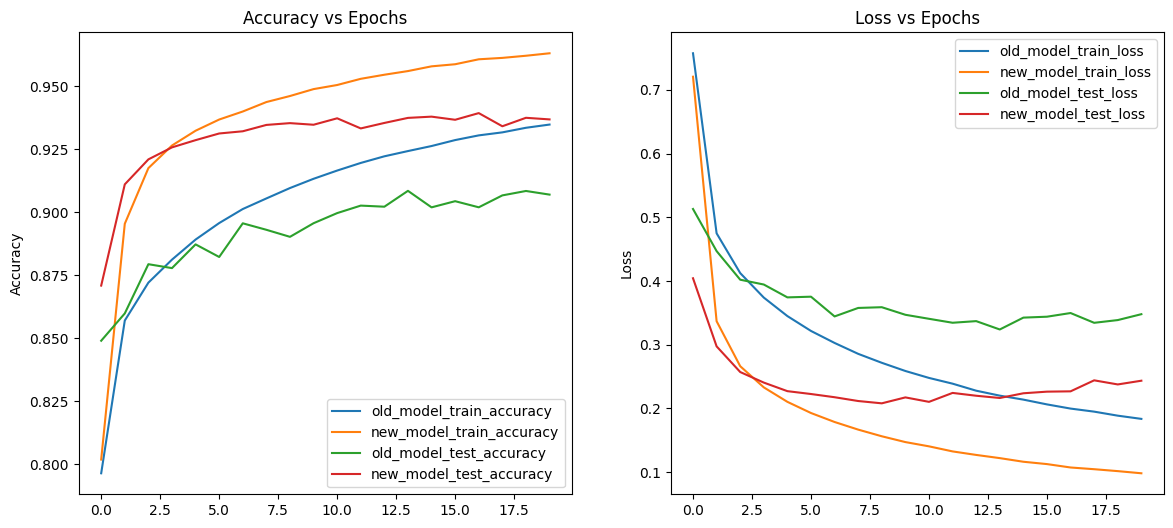

In [70]:
#Plotting Results
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
epochs=np.arange(20)
plt.title('Accuracy vs Epochs')
plt.plot(epochs,model_history.history['accuracy'],label='old_model_train_accuracy')
plt.plot(epochs,model_history2.history['accuracy'],label='new_model_train_accuracy')
plt.ylabel('Accuracy')
plt.plot(epochs,model_history.history['val_accuracy'],label='old_model_test_accuracy')
plt.plot(epochs,model_history2.history['val_accuracy'],label='new_model_test_accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss vs Epochs')
plt.plot(epochs,model_history.history['loss'],label='old_model_train_loss')
plt.plot(epochs,model_history2.history['loss'],label='new_model_train_loss')
plt.ylabel('Loss')
plt.plot(epochs,model_history.history['val_loss'],label='old_model_test_loss')
plt.plot(epochs,model_history2.history['val_loss'],label='new_model_test_loss')
plt.legend()
plt.show()

## **Conclusions**
- The accuracy for the new model is more compared to a simpler architecture, this proves the model still has scope and 
  can be improved
- Similar case for losses as the new model has attained less loss after 20 epochs compared to old model

## PART G - NETWORK INITIALIZATION (10 POINTS)
On your Deep Learning model

Change the network initialization. How does it affect accuracy? How does it affect how quickly the network plateaus?
Various forms of network initialization:
- Zero 0
- UniformGaussian
- Xavier
- Glorot Initialization http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initializationXavier
- Uniform
- Xavier Gaussian


In [72]:
tf.keras.initializers.Zeros()

In [78]:
#ModelDefinition
intializers= [initializers.Zeros(),   ## Intilializing all weights as Zeros
              initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),  ## Intilializing all weights from gaussian with mean 0, std 0.02
              initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), ## Intilializing all weights from uniform between -0.05 to 0.05
              initializers.GlorotNormal(seed=None), ## Intilializing all weights with Xavier also called Glorot Normal
              initializers.GlorotUniform(seed=None)] ## Intilializing all weights with Xavier Uniform
intializers_names = ['Zeros','Gaussian','Uniform','Xavier Gaussian','Xavier Uniform']
accuracies_intializers = []
models_intializers = []
time_taken_intializers = []

for i,intializer in enumerate(intializers):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(512,activation='relu',kernel_initializer=intializer))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_unique_chars, activation='softmax'))
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    start = time.time()
    models_intializers.append(model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=0,batch_size=128))
    time_taken_intializers.append(time.time() - start)
    accuracies_intializers.append(models_losses[i].history['accuracy'][-1])



2022-11-19 20:48:33.376934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 20:48:46.401200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 20:53:40.226134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 20:53:54.623463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 20:58:42.277518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 20:58:57.641866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 21:03:31.110630: I tensorflow/core/grappler/optimizers/cust

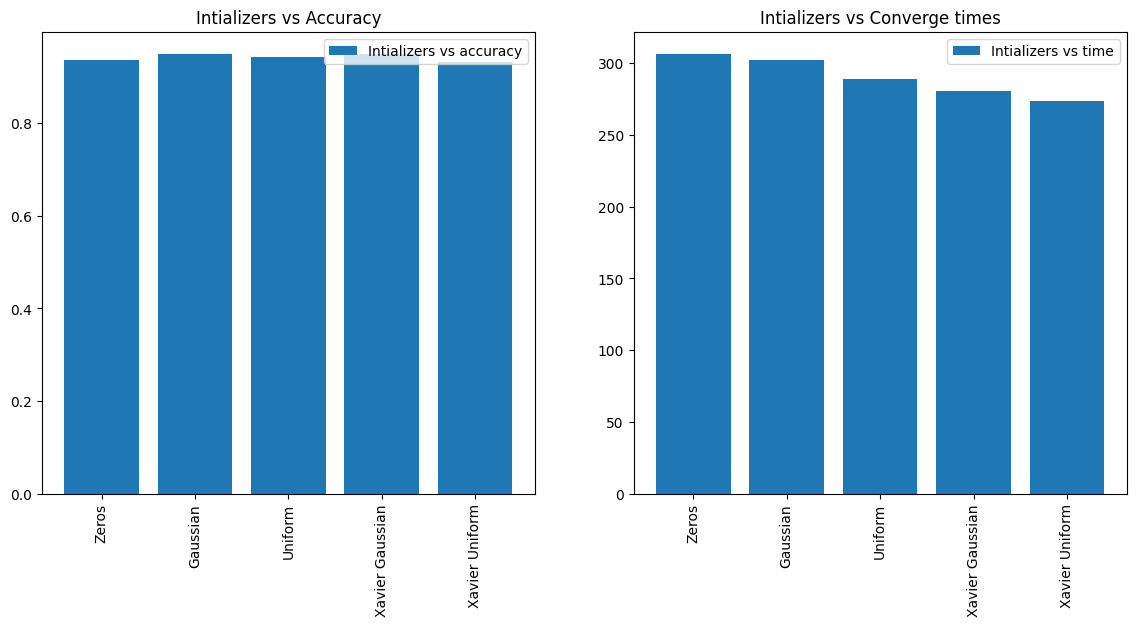

In [105]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title('Intializers vs Accuracy')
plt.xticks(rotation='vertical')
plt.bar(intializers_names,accuracies_intializers,label='Intializers vs accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.title('Intializers vs Converge times')
plt.xticks(rotation='vertical')
plt.bar(intializers_names,time_taken_intializers,label='Intializers vs time')
plt.legend()
plt.show()

## **Conclusions**
- The accuracy for all intilaizers was alsmost same which is surprising as model converged with even zero weights
- The time taken was less for Xavier uniform and more for Zero which was expected

References

https://keras.io/api/layers/initializers/

MIT License

Copyright (c) 2022 Prasanth Dwadasi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.